<a href="https://colab.research.google.com/github/Nandana-vijayan/Evaluating-the-Effectiveness-of-SMOTE-and-SMOTE-ENC-in-Class-Imbalance-Medical-Data/blob/main/3_SMOTENC_balanced_Exasens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as coppds
import matplotlib.pyplot as pltcopd

salivaco = coppds.read_csv('/content/drive/MyDrive/Exasens_final.csv')
salivaco

,Diagnosis,Imaginary Part (Min Δ),Imaginary Part (Avg Δ),Real Part (Min Δ),Real Part (Avg Δ),Gender,Age,Smoking
0,1,-320.61,-300.563531,-495.26,-464.171991,1,77,2
1,1,-325.39,-314.750359,-473.73,-469.263140,0,72,2
2,1,-323.00,-317.436056,-476.12,-471.897667,1,73,3
3,1,-327.78,-317.399670,-473.73,-468.856388,1,76,2
4,1,-325.39,-316.155785,-478.52,-472.869783,0,65,2
...,...,...,...,...,...,...,...,...
95,3,-323.00,-314.384434,-476.12,-472.103689,1,38,1
96,3,-323.00,-314.323628,-476.12,-472.395413,1,36,1
97,3,-323.00,-312.856656,-480.91,-472.294281,0,33,1
98,3,-327.78,-319.305447,-476.12,-471.776918,1,43,1


In [5]:
salivaco['Diagnosis'].value_counts()

,count
Diagnosis,
1,40
2,40
0,10
3,10


the data is imbalanced

Balancing data using SMOTEENC

In [6]:
!pip install imbalanced-learn

In [7]:
from sklearn.model_selection import train_test_split as sal_ttsplit
from imblearn.over_sampling import SMOTENC as salsmotenc

salXX = salivaco.drop('Diagnosis', axis=1)
salyy = salivaco['Diagnosis']

XXtrain, XXtest, yytrain, yytest = sal_ttsplit(salXX, salyy, test_size=0.2, random_state=1)

catfeature = [salXX.columns.get_loc(col) for col in ['Gender', 'Smoking']] # categorical feature indices

salsmen = salsmotenc(categorical_features=catfeature, random_state=1)
XXresam, yyresam = salsmen.fit_resample(XXtrain, yytrain)

In [8]:
XXresam.shape, XXtest.shape

((132, 7), (20, 7))

In [9]:
print(coppds.Series(yyresam).value_counts())

Diagnosis
1    33
2    33
3    33
0    33
Name: count, dtype: int64


In [10]:
print(coppds.Series(yytest).value_counts())

Diagnosis
1    7
2    7
0    4
3    2
Name: count, dtype: int64


In [11]:
from sklearn.metrics import classification_report as classisal
from sklearn.metrics import average_precision_score as avgpresal
from sklearn.metrics import matthews_corrcoef as MCCsal
from sklearn.model_selection import GridSearchCV as gridsearsal
from sklearn.metrics import precision_recall_curve as prerecsal
from sklearn.metrics import confusion_matrix as matrixsal
from sklearn.metrics import balanced_accuracy_score as balnaccsal
from sklearn.metrics import roc_auc_score as rocaucsal
from sklearn.metrics import ConfusionMatrixDisplay as dispmatrixsal
import warnings as salwar
salwar.filterwarnings("ignore")

**Decision Tree Classification Model**

In [12]:
from sklearn.tree import DecisionTreeClassifier as saldtcpd

dt_sal = saldtcpd()

gridsal = {'criterion': ['gini', 'log_loss', 'entropy'],
            'splitter': ['random', 'best'],
            'max_depth': [None, 10, 20, 30],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [2, 5, 10]}

copdgridsal = gridsearsal(dt_sal, param_grid=gridsal, cv=5, scoring='accuracy', verbose=1)
copdgridsal.fit(XXresam, yyresam)
decclas = copdgridsal.best_estimator_
print("best parameters of decision tree:")
print(copdgridsal.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
best parameters of decision tree:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'splitter': 'random'}


Test.decision tree:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.78      1.00      0.88         7
           2       0.50      0.29      0.36         7
           3       0.50      1.00      0.67         2

    accuracy                           0.60        20
   macro avg       0.53      0.63      0.55        20
weighted avg       0.56      0.60      0.56        20

Test.balanced accuracy:
0.6339285714285714
Test.MCC:
0.4607260390794856
Test.AUPRC:
0.576360544217687


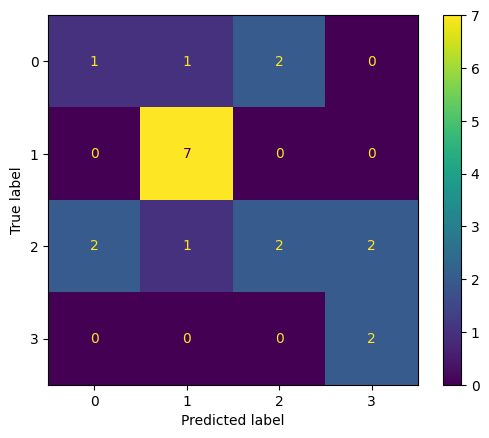

In [13]:
saltest_pred = decclas.predict(XXtest)
saltest_prob = decclas.predict_proba(XXtest)
print("Test.decision tree:")
print(classisal(yytest, saltest_pred))
print("Test.balanced accuracy:")
print(balnaccsal(yytest, saltest_pred))
print("Test.MCC:")
print(MCCsal(yytest, saltest_pred))
print("Test.AUPRC:")
print(avgpresal(yytest, saltest_prob))
tstcmm = matrixsal(yytest, saltest_pred)
dispmatrixsal(confusion_matrix=tstcmm).plot()

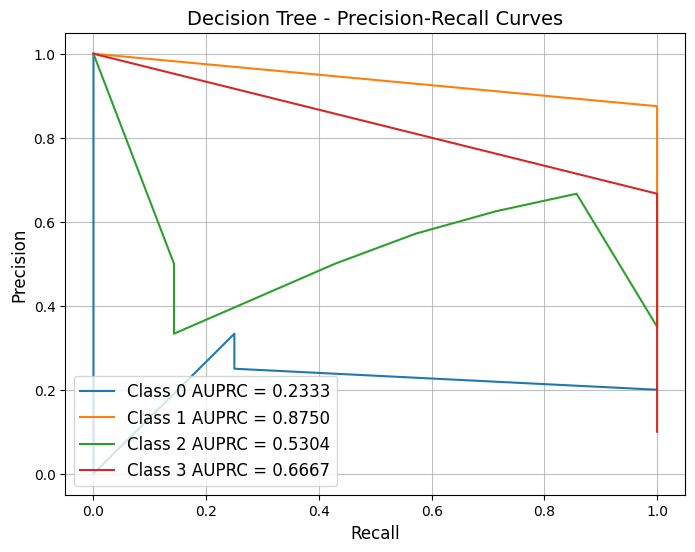

In [14]:
pltcopd.figure(figsize=(8, 6))
outpt_clas = 4 ###(multi-class)

presaldict = {}
recsaldict = {}
auprcsaldict = {}

for iss in range(outpt_clas):
    precision, recall, _ = prerecsal(yytest == iss, saltest_prob[:, iss]) ## computing for each class
    salauprc = avgpresal(yytest == iss, saltest_prob[:, iss])
    presaldict[iss] = precision
    recsaldict[iss] = recall
    auprcsaldict[iss] = salauprc

for iss in range(outpt_clas):
    pltcopd.plot(recsaldict[iss], presaldict[iss], label=f'Class {iss} AUPRC = {auprcsaldict[iss]:.4f}')

pltcopd.xlabel('Recall', fontsize=12)
pltcopd.ylabel('Precision', fontsize=12)
pltcopd.title('Decision Tree - Precision-Recall Curves', fontsize=14)
pltcopd.legend(loc='lower left', fontsize=12)
pltcopd.grid(alpha=0.8)
pltcopd.show()

**Random Forest Classification Model**

In [15]:
from sklearn.ensemble import RandomForestClassifier as salrfcpd

rf_sal = salrfcpd()

gridsal = {
    'criterion': ['gini', 'log_loss', 'entropy'],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 20, None],
    'class_weight': [None, 'balanced']
}

copdgridsal = gridsearsal(rf_sal, param_grid=gridsal, cv=5, scoring='accuracy', verbose=1)
copdgridsal.fit(XXresam, yyresam)
rffclas = copdgridsal.best_estimator_
print("best parameters of randomforest:")
print(copdgridsal.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
best parameters of randomforest:
{'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


Test.randomforest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.88      1.00      0.93         7
           2       0.62      0.71      0.67         7
           3       0.67      1.00      0.80         2

    accuracy                           0.70        20
   macro avg       0.54      0.68      0.60        20
weighted avg       0.59      0.70      0.64        20

Test.balanced accuracy:
0.6785714285714286
Test.MCC:
0.581275324310956
Test.AUPRC:
0.8015873015873015


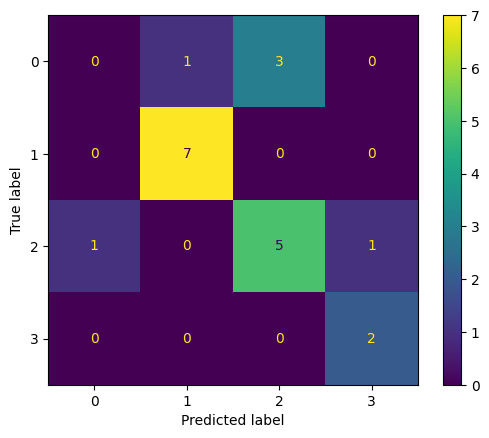

In [16]:
saltest_pred = rffclas.predict(XXtest)
saltest_prob = rffclas.predict_proba(XXtest)
print("Test.randomforest:")
print(classisal(yytest, saltest_pred))
print("Test.balanced accuracy:")
print(balnaccsal(yytest, saltest_pred))
print("Test.MCC:")
print(MCCsal(yytest, saltest_pred))
print("Test.AUPRC:")
print(avgpresal(yytest, saltest_prob))
tstcmm = matrixsal(yytest, saltest_pred)
dispmatrixsal(confusion_matrix=tstcmm).plot()

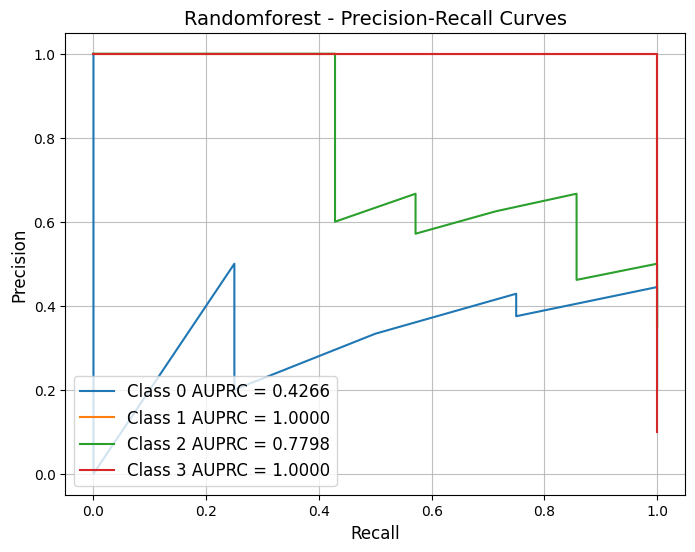

In [17]:
pltcopd.figure(figsize=(8, 6))
outpt_clas = 4 ###(multi-class)

presaldict = {}
recsaldict = {}
auprcsaldict = {}

for iss in range(outpt_clas):
    precision, recall, _ = prerecsal(yytest == iss, saltest_prob[:, iss]) ## computing for each class
    salauprc = avgpresal(yytest == iss, saltest_prob[:, iss])
    presaldict[iss] = precision
    recsaldict[iss] = recall
    auprcsaldict[iss] = salauprc

for iss in range(outpt_clas):
    pltcopd.plot(recsaldict[iss], presaldict[iss], label=f'Class {iss} AUPRC = {auprcsaldict[iss]:.4f}')

pltcopd.xlabel('Recall', fontsize=12)
pltcopd.ylabel('Precision', fontsize=12)
pltcopd.title('Randomforest - Precision-Recall Curves', fontsize=14)
pltcopd.legend(loc='lower left', fontsize=12)
pltcopd.grid(alpha=0.8)
pltcopd.show()

**Support Vector Machine**

In [18]:
from sklearn.svm import SVC as salsvmcpd

svm_sal = salsvmcpd(probability=True)

gridsal = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

copdgridsal = gridsearsal(svm_sal, param_grid=gridsal, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
copdgridsal.fit(XXresam, yyresam)
svmclas = copdgridsal.best_estimator_
print("best parameters of svm:")
print(copdgridsal.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best parameters of svm:
{'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


Test.SVM:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.70      1.00      0.82         7
           2       0.75      0.43      0.55         7
           3       0.67      1.00      0.80         2

    accuracy                           0.65        20
   macro avg       0.61      0.67      0.61        20
weighted avg       0.64      0.65      0.62        20

Test.balanced accuracy:
0.6696428571428572
Test.MCC:
0.5257715951596812
Test.AUPRC:
0.6676853433681165


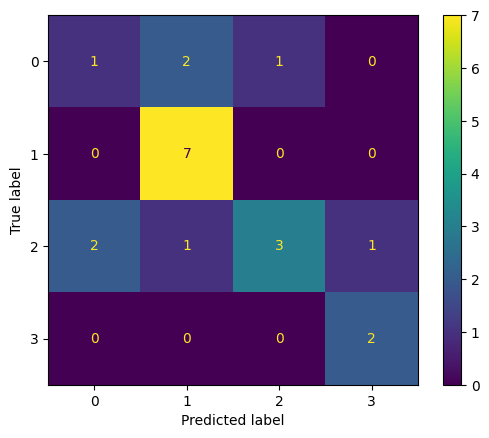

In [19]:
saltest_pred = svmclas.predict(XXtest)
saltest_prob = svmclas.predict_proba(XXtest)
print("Test.SVM:")
print(classisal(yytest, saltest_pred))
print("Test.balanced accuracy:")
print(balnaccsal(yytest, saltest_pred))
print("Test.MCC:")
print(MCCsal(yytest, saltest_pred))
print("Test.AUPRC:")
print(avgpresal(yytest, saltest_prob))
tstcmm = matrixsal(yytest, saltest_pred)
dispmatrixsal(confusion_matrix=tstcmm).plot()

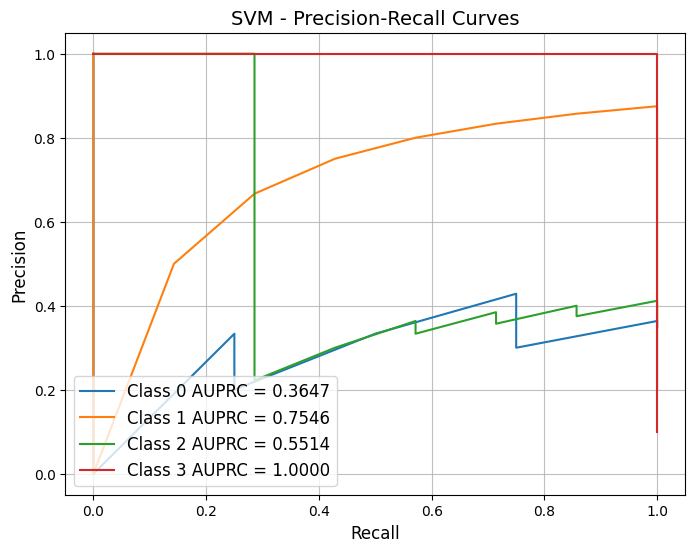

In [20]:
pltcopd.figure(figsize=(8, 6))
outpt_clas = 4 ###(multi-class)

presaldict = {}
recsaldict = {}
auprcsaldict = {}

for iss in range(outpt_clas):
    precision, recall, _ = prerecsal(yytest == iss, saltest_prob[:, iss]) ## computing for each class
    salauprc = avgpresal(yytest == iss, saltest_prob[:, iss])
    presaldict[iss] = precision
    recsaldict[iss] = recall
    auprcsaldict[iss] = salauprc

for iss in range(outpt_clas):
    pltcopd.plot(recsaldict[iss], presaldict[iss], label=f'Class {iss} AUPRC = {auprcsaldict[iss]:.4f}')

pltcopd.xlabel('Recall', fontsize=12)
pltcopd.ylabel('Precision', fontsize=12)
pltcopd.title('SVM - Precision-Recall Curves', fontsize=14)
pltcopd.legend(loc='lower left', fontsize=12)
pltcopd.grid(alpha=0.8)
pltcopd.show()